# Trial-Averaged Movies for Wheel Task

## What this does:
For each of 4 conditions (left_before, left_stim, right_before, right_stim):
1. Load frame indices from CSV files (rows = trials, columns = frame positions)
2. For each frame position (1, 2, ... 17), average across all trials
3. Result: 17-frame movie showing temporal evolution of trial-averaged activity

- `left_stim` CSV has 37 trials × 17 frames
- Frame position 1: average frames [898, 1687, 2350, ...] (first stim frame from each trial)
- Frame position 2: average frames [899, 1688, 2351, ...] (second stim frame from each trial)
- Output: 17-frame movie where each frame is the trial-averaged image at that time point
- **Before** conditions: take LAST 17 frames (leading up to stim onset)
- **Stim** conditions: take FIRST 17 frames (after stim onset)

All outputs have same shape `(17, H, W)`

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mbo_utilities as mbo
from tifffile import imwrite

## Load and visualize registered frames via behavioral indices

In [3]:
output_dir = Path("D://demo//behavior")
output_dir.mkdir(exist_ok=True)

# Paths
s2p_dir = Path(r"\\rbo-w1\D\W1_DATA\wsnyder\2025-10-16-Females-Shank-Wheel-316902\suite2p")
avg_frames_dir = Path(r"\\rbo-w1\W1_E_USER_DATA\foconnell\lbm\wsnyder")

print(f"Suite2p dir: {s2p_dir}")
print(f"CSV dir: {avg_frames_dir}")
print(f"Output dir: {output_dir}")

Suite2p dir: \\rbo-w1\D\W1_DATA\wsnyder\2025-10-16-Females-Shank-Wheel-316902\suite2p
CSV dir: \\rbo-w1\W1_E_USER_DATA\foconnell\lbm\wsnyder
Output dir: D:\demo\behavior


In [4]:
stitched_folders = sorted([p for p in s2p_dir.iterdir() if p.is_dir() and "stitched" in p.name])
for f in stitched_folders:
    print(f"  {f.name}")

  plane01_stitched
  plane02_stitched
  plane03_stitched
  plane04_stitched
  plane05_stitched
  plane06_stitched
  plane07_stitched
  plane08_stitched
  plane09_stitched
  plane10_stitched
  plane11_stitched
  plane12_stitched
  plane13_stitched
  plane14_stitched


In [5]:
# Load all 4 CSV tables
csv_files = {
    "left_before": avg_frames_dir / "Left_Frame_Table_Before.csv",
    "left_stim": avg_frames_dir / "Left_Frame_Table_Stim.csv",
    "right_before": avg_frames_dir / "Right_Frame_Table_Before.csv",
    "right_stim": avg_frames_dir / "Right_Frame_Table_Stim.csv",
}

frame_tables = {}
for name, path in csv_files.items():
    df = pd.read_csv(path)
    frame_tables[name] = df
    print(f"{name}: {df.shape[0]} trials with {df.shape[1]} frames/trial = {df.size} total frames")

left_before: 37 trials with 24 frames/trial = 888 total frames
left_stim: 37 trials with 17 frames/trial = 629 total frames
right_before: 10 trials with 24 frames/trial = 240 total frames
right_stim: 10 trials with 26 frames/trial = 260 total frames


In [6]:
# Preview one of the tables
print("Left Before table (first 5 rows):")
frame_tables["left_before"].head()

Left Before table (first 5 rows):


,Frame 1,Frame 2,Frame 3,Frame 4,Frame 5,Frame 6,Frame 7,Frame 8,Frame 9,Frame 10,...,Frame 15,Frame 16,Frame 17,Frame 18,Frame 19,Frame 20,Frame 21,Frame 22,Frame 23,Frame 24
0,874,875,876,877,878,879,880,881,882,883,...,888,889,890,891,892,893,894,895,896,897
1,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,...,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686
2,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
3,5377,5378,5379,5380,5381,5382,5383,5384,5385,5386,...,5391,5392,5393,5394,5395,5396,5397,5398,5399,5400
4,5849,5850,5851,5852,5853,5854,5855,5856,5857,5858,...,5863,5864,5865,5866,5867,5868,5869,5870,5871,5872


In [7]:
# Helper functions for trace extraction
def extract_trial_traces(F, frame_table, n_frames=17, use_last_n=False):
    """
    Extract fluorescence traces aligned to trial epochs.

    Args:
        F: fluorescence array (n_cells, n_total_frames)
        frame_table: DataFrame where rows=trials, columns=frame positions
        n_frames: number of frames to extract per trial
        use_last_n: if True, take last n_frames (for "before" conditions)

    Returns:
        traces: (n_trials, n_cells, n_frames) array
    """
    n_cells = F.shape[0]
    n_trials = len(frame_table)
    n_cols = frame_table.shape[1]

    if use_last_n:
        cols = list(range(n_cols - n_frames, n_cols))
    else:
        cols = list(range(n_frames))

    traces = np.zeros((n_trials, n_cells, n_frames), dtype=np.float32)

    for trial_idx in range(n_trials):
        for i, col_idx in enumerate(cols):
            frame_idx = int(frame_table.iloc[trial_idx, col_idx])
            traces[trial_idx, :, i] = F[:, frame_idx]

    return traces

def zscore_traces(traces):
    """Z-score normalize each cell's trace (across time)."""
    mean = traces.mean(axis=-1, keepdims=True)
    std = traces.std(axis=-1, keepdims=True)
    std[std == 0] = 1
    return (traces - mean) / std

In [8]:
# Only process planes 1-8 (planes 9+ are too noisy - dura, not cortex)
planes_to_use = list(range(1, 9))
N_FRAMES_OUTPUT = 17

# Results for raw pixel movies
results = {cond: {} for cond in frame_tables.keys()}

# Results for fluorescence traces
traces_by_plane = {}
all_traces = {cond: [] for cond in frame_tables.keys()}

# Process each plane
for folder in stitched_folders:
    # Extract plane number
    plane_name = folder.name
    plane_num = int(''.join(filter(str.isdigit, plane_name.split("plane")[-1])))

    # Skip planes not in our list
    if plane_num not in planes_to_use:
        continue

    bin_path = folder / "data.bin"
    if not bin_path.is_file():
        print(f"Skipping {folder.name} - no data.bin")
        continue

    print(f"\nProcessing {plane_name}...")

    # === Part 1: Raw pixel movie averaging ===
    data = mbo.imread(bin_path)
    H, W = data.shape[1], data.shape[2]
    print(f"  Data shape: {data.shape}")

    for condition, df in frame_tables.items():
        n_trials, n_frame_positions = df.shape

        # Before: last 17 frames, Stim: first 17 frames
        if "before" in condition:
            frame_cols = list(range(n_frame_positions - N_FRAMES_OUTPUT, n_frame_positions))
        else:
            frame_cols = list(range(N_FRAMES_OUTPUT))

        # Create movie: average across trials for each frame position
        avg_movie = np.zeros((N_FRAMES_OUTPUT, H, W), dtype=np.float32)
        for i, frame_col in enumerate(frame_cols):
            indices = df.iloc[:, frame_col].astype(int).values
            avg_movie[i] = data[indices, :, :].mean(axis=0)

        results[condition][plane_num] = avg_movie
        out_path = output_dir / f"{condition}_plane{plane_num}.tif"
        imwrite(out_path, avg_movie)
        print(f"  {condition}: {n_trials} trials -> {out_path.name}")

    # === Part 2: Load Suite2p fluorescence traces ===
    F_path = folder / "F.npy"
    if F_path.exists():
        F = np.load(F_path)
        Fneu = np.load(folder / "Fneu.npy")
        spks = np.load(folder / "spks.npy")
        stat = np.load(folder / "stat.npy", allow_pickle=True)
        iscell = np.load(folder / "iscell.npy", allow_pickle=True)

        cell_mask = iscell[:, 0].astype(bool)
        traces_by_plane[plane_num] = {
            'F': F[cell_mask],
            'Fneu': Fneu[cell_mask],
            'spks': spks[cell_mask],
            'stat': [s for s, ic in zip(stat, cell_mask) if ic],
            'n_cells': cell_mask.sum()
        }
        print(f"  Loaded {cell_mask.sum()} cells from Suite2p")

        # Extract trial-averaged traces for each condition
        for cond, df in frame_tables.items():
            use_last = "before" in cond
            traces = extract_trial_traces(F[cell_mask], df, n_frames=17, use_last_n=use_last)
            trial_avg = traces.mean(axis=0)  # (n_cells, n_frames)
            all_traces[cond].append(trial_avg)

# Stack all planes into single arrays
for cond in all_traces:
    all_traces[cond] = np.vstack(all_traces[cond])
    print(f"{cond}: {all_traces[cond].shape} (cells, frames)")

print(f"\nTotal cells: {all_traces['left_stim'].shape[0]}")


Processing plane01_stitched...
  Data shape: (21880, 594, 458)
  left_before: 37 trials -> left_before_plane1.tif
  left_stim: 37 trials -> left_stim_plane1.tif
  right_before: 10 trials -> right_before_plane1.tif
  right_stim: 10 trials -> right_stim_plane1.tif
  Loaded 15 cells from Suite2p

Processing plane02_stitched...
  Data shape: (21880, 594, 458)
  left_before: 37 trials -> left_before_plane2.tif
  left_stim: 37 trials -> left_stim_plane2.tif
  right_before: 10 trials -> right_before_plane2.tif
  right_stim: 10 trials -> right_stim_plane2.tif
  Loaded 32 cells from Suite2p

Processing plane03_stitched...
  Data shape: (21880, 594, 458)
  left_before: 37 trials -> left_before_plane3.tif
  left_stim: 37 trials -> left_stim_plane3.tif
  right_before: 10 trials -> right_before_plane3.tif
  right_stim: 10 trials -> right_stim_plane3.tif
  Loaded 32 cells from Suite2p

Processing plane04_stitched...
  Data shape: (21880, 594, 458)
  left_before: 37 trials -> left_before_plane4.tif


In [9]:
# Stack planes into 4D volumes (T, Z, H, W) for napari
volumes = {}
for condition in results.keys():
    plane_movies = [results[condition][p] for p in planes_to_use if p in results[condition]]
    volume = np.stack(plane_movies, axis=0)  # (Z, T, H, W)
    volume = volume.transpose(1, 0, 2, 3)     # (T, Z, H, W)
    volumes[condition] = volume

    volume_path = output_dir / f"{condition}_volume.tif"
    imwrite(volume_path, volume.astype(np.float32))
    print(f"{condition}: {volume.shape} (T, Z, H, W)")

left_before: (17, 8, 594, 458) (T, Z, H, W)
left_stim: (17, 8, 594, 458) (T, Z, H, W)
right_before: (17, 8, 594, 458) (T, Z, H, W)
right_stim: (17, 8, 594, 458) (T, Z, H, W)


In [10]:
# Compute difference movies: stim - before (frame by frame)
# Shows what changes when stim turns on vs the baseline period before

diff_left_vol = volumes["left_stim"] - volumes["left_before"]
diff_right_vol = volumes["right_stim"] - volumes["right_before"]

# Also compute left vs right after stim
diff_left_vs_right_stim = volumes["left_stim"] - volumes["right_stim"]

imwrite(output_dir / "diff_left_stim_minus_before.tif", diff_left_vol.astype(np.float32))
imwrite(output_dir / "diff_right_stim_minus_before.tif", diff_right_vol.astype(np.float32))
imwrite(output_dir / "diff_left_vs_right_stim.tif", diff_left_vs_right_stim.astype(np.float32))

print(f"Difference volumes saved: {diff_left_vol.shape} (T, Z, H, W)"

SyntaxError: incomplete input (1902545591.py, line 14)

In [ ]:
# View in napari - 4D volumes with time slider
import napari

viewer = napari.Viewer()

# scale=(T, Z, Y, X) - Z spacing ~6x larger than XY for proper 3D projection
scale = (1, 6, 1, 1)

viewer.add_image(volumes["left_before"], name="Left Before", colormap='gray', scale=scale)
viewer.add_image(volumes["left_stim"], name="Left Stim", colormap='gray', visible=False, scale=scale)
viewer.add_image(volumes["right_before"], name="Right Before", colormap='gray', visible=False, scale=scale)
viewer.add_image(volumes["right_stim"], name="Right Stim", colormap='gray', visible=False, scale=scale)

# Add difference volumes (RdBu colormap: blue=negative, red=positive)
viewer.add_image(diff_left_vol, name="Left: Stim-Before", colormap='RdBu_r', visible=False, scale=scale)
viewer.add_image(diff_right_vol, name="Right: Stim-Before", colormap='RdBu_r', visible=False, scale=scale)
viewer.add_image(diff_left_vs_right_stim, name="Left vs Right (Stim)", colormap='RdBu_r', visible=False, scale=scale)

viewer.show(block=True)

### Output Files

**Individual plane movies** (T=17, H=594, W=458):
- `{condition}_plane{N}.tif` - Each plane's trial-averaged movie

**4D volumes for napari** (T=17, Z=8, H=594, W=458):
- `left_before_volume.tif` - Last 17 frames before stim, averaged across 37 trials
- `left_stim_volume.tif` - First 17 frames of stim, averaged across 37 trials  
- `right_before_volume.tif` - Last 17 frames before stim, averaged across 10 trials
- `right_stim_volume.tif` - First 17 frames of stim, averaged across 10 trials

**Difference movies** (pixel-wise subtraction):
- `diff_left_stim_minus_before.tif` - What changes when left stim turns on
- `diff_right_stim_minus_before.tif` - What changes when right stim turns on
- `diff_left_vs_right_stim.tif` - Left vs right activation during stim

---

## Fluorescence Trace Analysis (Suite2p ROIs)

The above analysis uses raw pixel values from `data.bin`. Below we use Suite2p's 
extracted **fluorescence traces (F)** from identified cell ROIs.

This lets us see how individual neurons respond to trials, not just raw pixel intensity.

### Heatmaps: unsorted and rastermap-sorted

Showing raw cell order (unsorted) and rastermap-sorted views.
Peak-time sorting creates artificial diagonals and is not used.

In [ ]:
# Filter out low-activity cells (likely noise)
# Keep only cells with some variance in their response

def filter_active_cells(traces_dict, min_std=0.1):
    """Remove cells with very low activity (likely noise)."""
    # Use left_stim as reference for filtering
    ref = traces_dict["left_stim"]
    cell_std = ref.std(axis=1)
    active_mask = cell_std > min_std

    filtered = {}
    for cond, data in traces_dict.items():
        filtered[cond] = data[active_mask]

    print(f"Kept {active_mask.sum()} / {len(active_mask)} cells (filtered low-activity)")
    return filtered, active_mask

all_traces_filtered, active_mask = filter_active_cells(all_traces)

NameError: name 'all_traces' is not defined

In [ ]:
# heatmaps: unsorted and rastermap-sorted
from rastermap import Rastermap

conditions = [
    ("left_before", "left before"),
    ("left_stim", "left stim"),
    ("right_before", "right before"),
    ("right_stim", "right stim"),
]

# fit rastermap on left_stim (use this order for all conditions)
X_left_stim = zscore_traces(all_traces_filtered["left_stim"])
n_cells = X_left_stim.shape[0]
n_clust = min(50, n_cells // 4)
n_pcs = min(X_left_stim.shape[1], 17)

model = Rastermap(n_clusters=n_clust, n_PCs=n_pcs, locality=0.0, verbose=False).fit(X_left_stim)
rastermap_order = model.isort

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle("trial-averaged neural activity", fontsize=14)

for col, (cond, title) in enumerate(conditions):
    data = all_traces_filtered[cond]
    zdata = zscore_traces(data)

    # top row: unsorted
    ax = axes[0, col]
    im = ax.imshow(zdata, aspect='auto', cmap='viridis',
                   extent=[1, 17, len(zdata), 0], vmin=-2, vmax=2)
    ax.set_xlabel("frame")
    ax.set_ylabel("cells (unsorted)")
    ax.set_title(f"{title} - unsorted")
    plt.colorbar(im, ax=ax, label='z-score')

    # bottom row: rastermap sorted
    ax = axes[1, col]
    im = ax.imshow(zdata[rastermap_order], aspect='auto', cmap='viridis',
                   extent=[1, 17, len(rastermap_order), 0], vmin=-2, vmax=2)
    ax.set_xlabel("frame")
    ax.set_ylabel("cells (rastermap)")
    ax.set_title(f"{title} - rastermap")
    plt.colorbar(im, ax=ax, label='z-score')

plt.tight_layout()
plt.show()

## Population Average Traces

Average activity across ALL cells at each frame. Compares:
- Left panel: Before vs Stim for LEFT trials
- Middle panel: Before vs Stim for RIGHT trials  
- Right panel: Left vs Right during STIM period

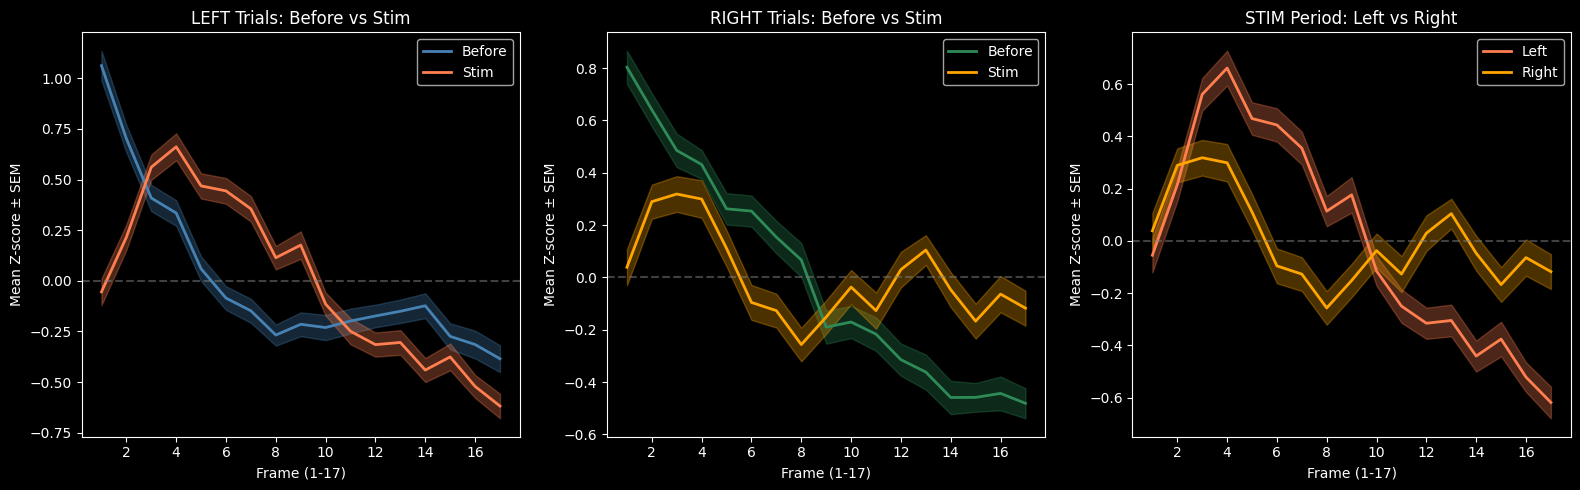

In [ ]:
# Population average traces (using filtered cells)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
frames = np.arange(1, 18)

colors = {'left_before': 'steelblue', 'left_stim': 'coral',
          'right_before': 'seagreen', 'right_stim': 'orange'}

# Panel 1: Left trials (before vs stim)
ax = axes[0]
for cond in ['left_before', 'left_stim']:
    zdata = zscore_traces(all_traces_filtered[cond])
    pop_mean = zdata.mean(axis=0)
    pop_sem = zdata.std(axis=0) / np.sqrt(len(zdata))

    label = "Before" if "before" in cond else "Stim"
    ax.fill_between(frames, pop_mean - pop_sem, pop_mean + pop_sem,
                    alpha=0.3, color=colors[cond])
    ax.plot(frames, pop_mean, color=colors[cond], linewidth=2, label=label)

ax.set_xlabel("Frame (1-17)")
ax.set_ylabel("Mean Z-score ± SEM")
ax.set_title("LEFT Trials: Before vs Stim")
ax.legend()
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Panel 2: Right trials (before vs stim)
ax = axes[1]
for cond in ['right_before', 'right_stim']:
    zdata = zscore_traces(all_traces_filtered[cond])
    pop_mean = zdata.mean(axis=0)
    pop_sem = zdata.std(axis=0) / np.sqrt(len(zdata))

    label = "Before" if "before" in cond else "Stim"
    ax.fill_between(frames, pop_mean - pop_sem, pop_mean + pop_sem,
                    alpha=0.3, color=colors[cond])
    ax.plot(frames, pop_mean, color=colors[cond], linewidth=2, label=label)

ax.set_xlabel("Frame (1-17)")
ax.set_ylabel("Mean Z-score ± SEM")
ax.set_title("RIGHT Trials: Before vs Stim")
ax.legend()
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Panel 3: Left vs Right during stim
ax = axes[2]
for cond in ['left_stim', 'right_stim']:
    zdata = zscore_traces(all_traces_filtered[cond])
    pop_mean = zdata.mean(axis=0)
    pop_sem = zdata.std(axis=0) / np.sqrt(len(zdata))

    label = "Left" if "left" in cond else "Right"
    ax.fill_between(frames, pop_mean - pop_sem, pop_mean + pop_sem,
                    alpha=0.3, color=colors[cond])
    ax.plot(frames, pop_mean, color=colors[cond], linewidth=2, label=label)

ax.set_xlabel("Frame (1-17)")
ax.set_ylabel("Mean Z-score ± SEM")
ax.set_title("STIM Period: Left vs Right")
ax.legend()
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Difference Heatmap: Stim minus Before

For each cell: how much MORE active is it during stim vs before?
- Yellow/red = cell activated by stim
- Blue = cell suppressed by stim

In [ ]:
# difference heatmaps: stim - before (using filtered cells)
diff_left = zscore_traces(all_traces_filtered["left_stim"]) - zscore_traces(all_traces_filtered["left_before"])
diff_right = zscore_traces(all_traces_filtered["right_stim"]) - zscore_traces(all_traces_filtered["right_before"])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("stim - before difference", fontsize=14)
vmax = 2

# top row: sorted by mean response magnitude
left_response = diff_left.mean(axis=1)
right_response = diff_right.mean(axis=1)
sort_by_response = np.argsort(left_response)[::-1]

ax = axes[0, 0]
im = ax.imshow(diff_left[sort_by_response], aspect='auto', cmap='RdBu_r',
               extent=[1, 17, len(sort_by_response), 0], vmin=-vmax, vmax=vmax)
ax.set_xlabel("frame")
ax.set_ylabel("cells (sorted by mean response)")
ax.set_title("left: stim - before")
plt.colorbar(im, ax=ax, label='delta z-score')

ax = axes[0, 1]
im = ax.imshow(diff_right[sort_by_response], aspect='auto', cmap='RdBu_r',
               extent=[1, 17, len(sort_by_response), 0], vmin=-vmax, vmax=vmax)
ax.set_xlabel("frame")
ax.set_ylabel("cells (same order)")
ax.set_title("right: stim - before")
plt.colorbar(im, ax=ax, label='delta z-score')

# bottom row: rastermap sorted
ax = axes[1, 0]
im = ax.imshow(diff_left[rastermap_order], aspect='auto', cmap='RdBu_r',
               extent=[1, 17, len(rastermap_order), 0], vmin=-vmax, vmax=vmax)
ax.set_xlabel("frame")
ax.set_ylabel("cells (rastermap)")
ax.set_title("left: stim - before (rastermap)")
plt.colorbar(im, ax=ax, label='delta z-score')

ax = axes[1, 1]
im = ax.imshow(diff_right[rastermap_order], aspect='auto', cmap='RdBu_r',
               extent=[1, 17, len(rastermap_order), 0], vmin=-vmax, vmax=vmax)
ax.set_xlabel("frame")
ax.set_ylabel("cells (rastermap)")
ax.set_title("right: stim - before (rastermap)")
plt.colorbar(im, ax=ax, label='delta z-score')

plt.tight_layout()
plt.show()

## Left vs Right Selectivity

Does each cell prefer LEFT or RIGHT trials?
- Selectivity = (Left - Right) / (|Left| + |Right|)
- +1 = only responds to Left
- -1 = only responds to Right
- 0 = responds equally to both

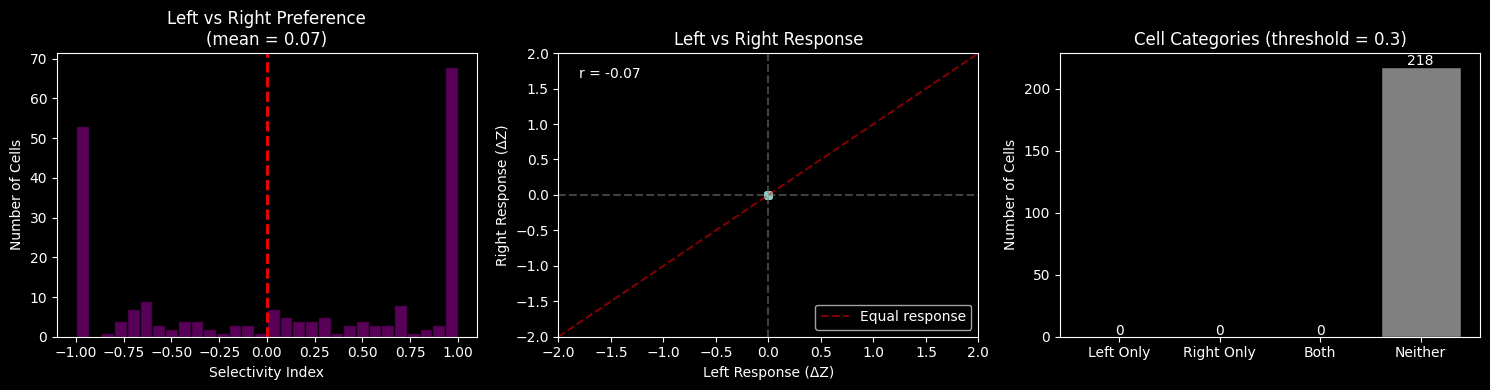

In [ ]:
# Left vs Right selectivity analysis (using filtered cells)
left_response = diff_left.mean(axis=1)
right_response = diff_right.mean(axis=1)

# Selectivity index
denom = np.abs(left_response) + np.abs(right_response)
denom[denom == 0] = 1
selectivity = (left_response - right_response) / denom

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
ax = axes[0]
ax.hist(selectivity, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel("Selectivity Index")
ax.set_ylabel("Number of Cells")
ax.set_title(f"Left vs Right Preference\n(mean = {selectivity.mean():.2f})")

# Scatter
ax = axes[1]
ax.scatter(left_response, right_response, alpha=0.5, s=30)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
lims = [-2, 2]
ax.plot(lims, lims, 'r--', alpha=0.5, label='Equal response')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Left Response (ΔZ)")
ax.set_ylabel("Right Response (ΔZ)")
ax.set_title("Left vs Right Response")
ax.legend()
corr = np.corrcoef(left_response, right_response)[0, 1]
ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, va='top')

# Categories
ax = axes[2]
thresh = 0.3
left_only = (left_response > thresh) & (right_response < thresh)
right_only = (right_response > thresh) & (left_response < thresh)
both = (left_response > thresh) & (right_response > thresh)
neither = (left_response < thresh) & (right_response < thresh)

categories = ['Left Only', 'Right Only', 'Both', 'Neither']
counts = [left_only.sum(), right_only.sum(), both.sum(), neither.sum()]
colors_bar = ['coral', 'orange', 'purple', 'gray']

bars = ax.bar(categories, counts, color=colors_bar, edgecolor='black')
ax.set_ylabel("Number of Cells")
ax.set_title(f"Cell Categories (threshold = {thresh})")
for bar, cnt in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, cnt + 1, str(cnt), ha='center')

plt.tight_layout()
plt.show()

---

# Part 3: Clustering

Group cells by their response patterns to find functionally similar neurons.

In [ ]:
from sklearn.cluster import KMeans

# Cluster based on stim responses (left + right combined)
X_left = zscore_traces(all_traces_filtered["left_stim"])
X_right = zscore_traces(all_traces_filtered["right_stim"])
X_combined = np.hstack([X_left, X_right])  # 34 features per cell

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_combined)

print(f"Clustered {len(cluster_labels)} cells into {n_clusters} groups:")
for i in range(n_clusters):
    print(f"  Cluster {i}: {(cluster_labels == i).sum()} cells")

Clustered 218 cells into 5 groups:
  Cluster 0: 36 cells
  Cluster 1: 47 cells
  Cluster 2: 50 cells
  Cluster 3: 42 cells
  Cluster 4: 43 cells


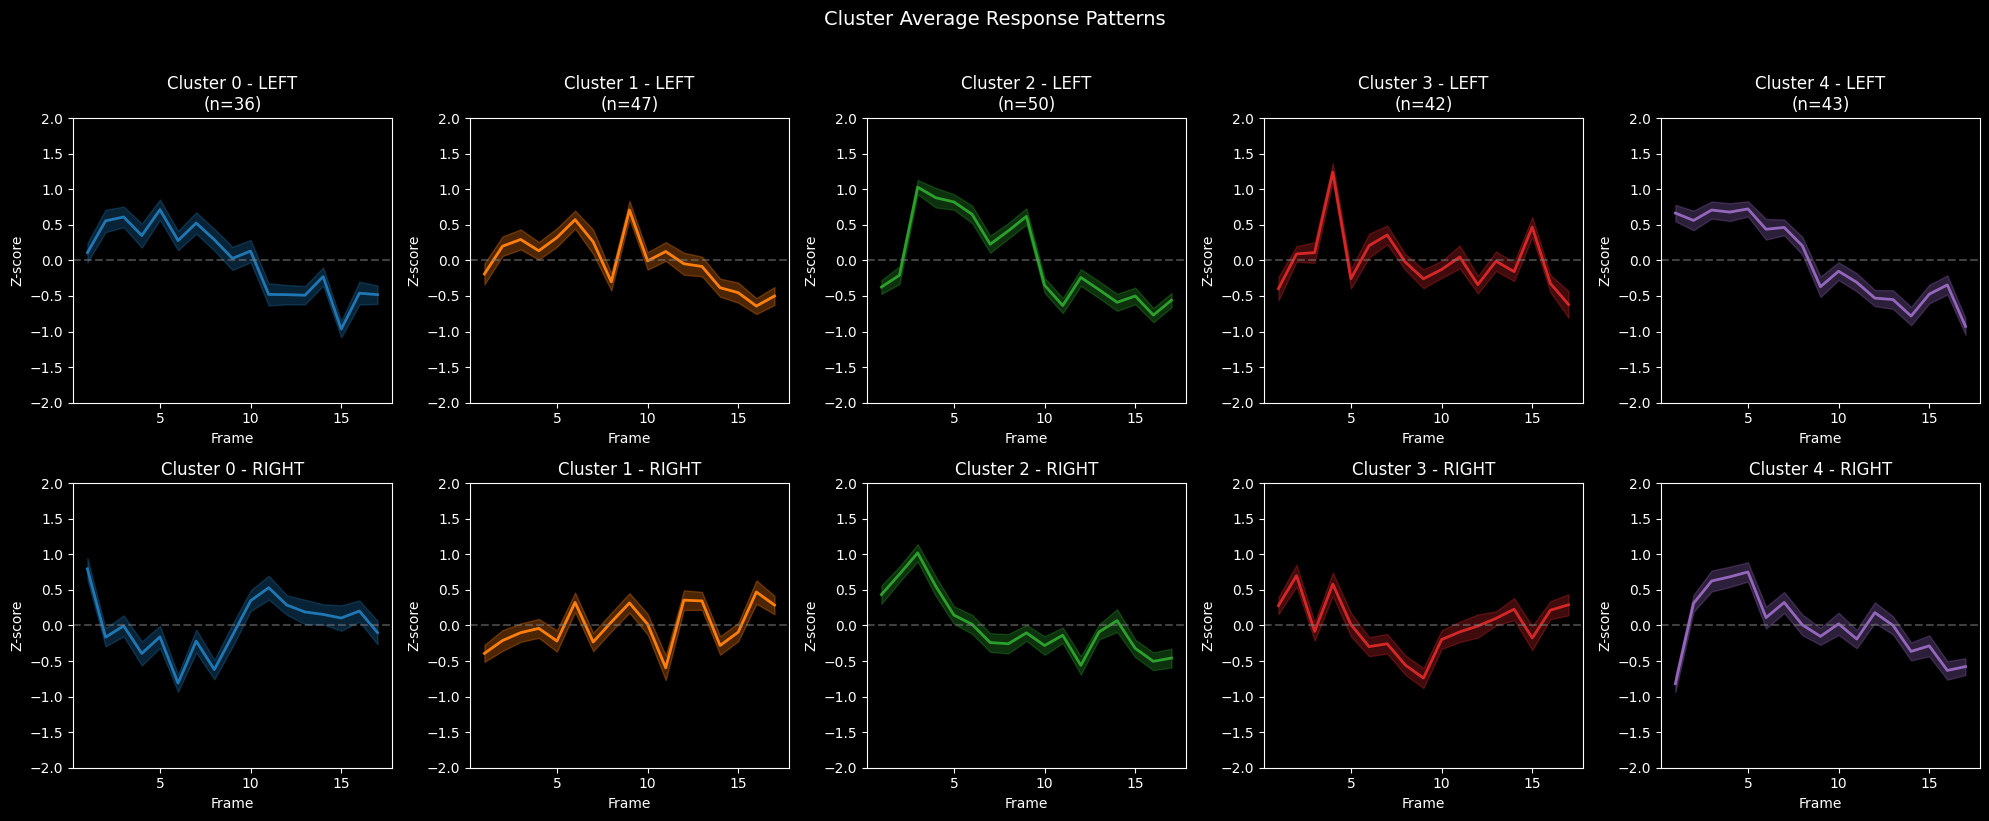

In [ ]:
# Average response pattern for each cluster
fig, axes = plt.subplots(2, n_clusters, figsize=(4*n_clusters, 8))
frames = np.arange(1, 18)
cluster_colors = plt.cm.tab10(np.arange(n_clusters))

for i in range(n_clusters):
    mask = cluster_labels == i
    n_in_cluster = mask.sum()

    # Left stim
    ax = axes[0, i]
    traces = X_left[mask]
    mean = traces.mean(axis=0)
    sem = traces.std(axis=0) / np.sqrt(n_in_cluster)
    ax.fill_between(frames, mean - sem, mean + sem, alpha=0.3, color=cluster_colors[i])
    ax.plot(frames, mean, color=cluster_colors[i], linewidth=2)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Z-score")
    ax.set_title(f"Cluster {i} - LEFT\n(n={n_in_cluster})")
    ax.set_ylim(-2, 2)

    # Right stim
    ax = axes[1, i]
    traces = X_right[mask]
    mean = traces.mean(axis=0)
    sem = traces.std(axis=0) / np.sqrt(n_in_cluster)
    ax.fill_between(frames, mean - sem, mean + sem, alpha=0.3, color=cluster_colors[i])
    ax.plot(frames, mean, color=cluster_colors[i], linewidth=2)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Z-score")
    ax.set_title(f"Cluster {i} - RIGHT")
    ax.set_ylim(-2, 2)

plt.suptitle("Cluster Average Response Patterns", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

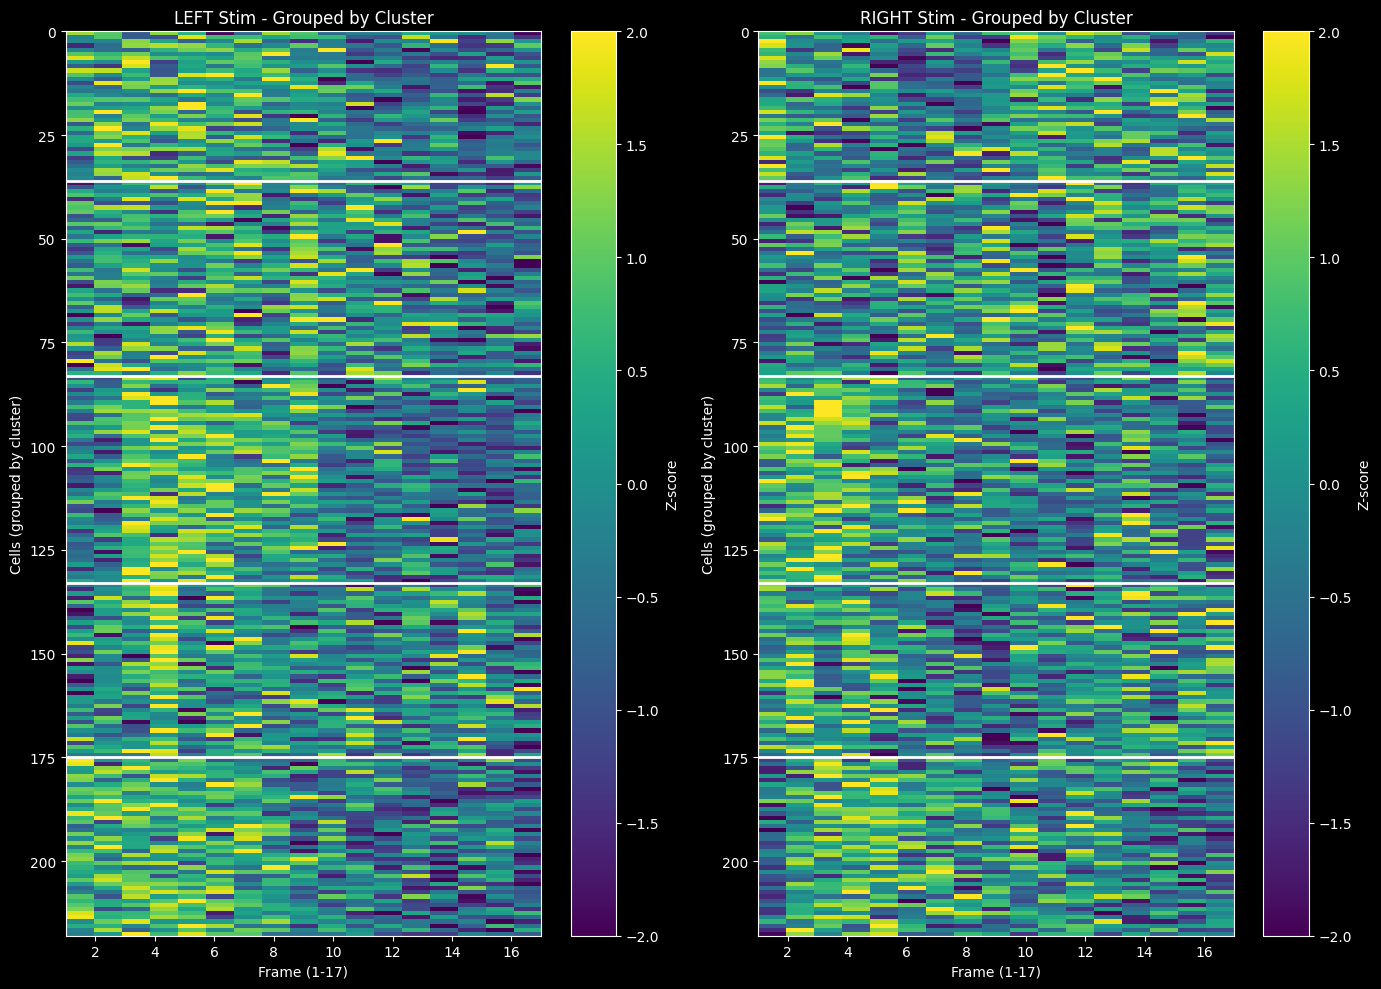

In [ ]:
# Heatmaps grouped by cluster (white lines separate clusters)
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
sort_idx = np.argsort(cluster_labels)

ax = axes[0]
im = ax.imshow(X_left[sort_idx], aspect='auto', cmap='viridis',
               extent=[1, 17, len(sort_idx), 0], vmin=-2, vmax=2)
ax.set_xlabel("Frame (1-17)")
ax.set_ylabel("Cells (grouped by cluster)")
ax.set_title("LEFT Stim - Grouped by Cluster")
plt.colorbar(im, ax=ax, label='Z-score')

# Add lines between clusters
cumsum = 0
for i in range(n_clusters - 1):
    cumsum += (cluster_labels == i).sum()
    ax.axhline(cumsum, color='white', linewidth=2)

ax = axes[1]
im = ax.imshow(X_right[sort_idx], aspect='auto', cmap='viridis',
               extent=[1, 17, len(sort_idx), 0], vmin=-2, vmax=2)
ax.set_xlabel("Frame (1-17)")
ax.set_ylabel("Cells (grouped by cluster)")
ax.set_title("RIGHT Stim - Grouped by Cluster")
plt.colorbar(im, ax=ax, label='Z-score')

cumsum = 0
for i in range(n_clusters - 1):
    cumsum += (cluster_labels == i).sum()
    ax.axhline(cumsum, color='white', linewidth=2)

plt.tight_layout()
plt.show()

## PCA: See all cells in 2D

Each dot = one cell. Cells close together have similar response patterns.

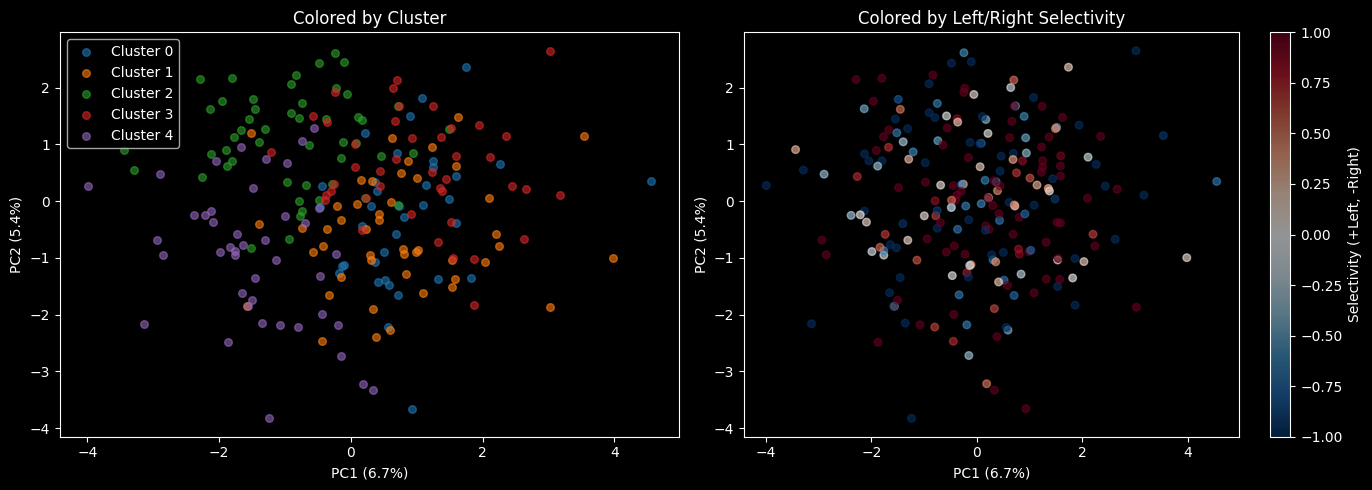

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color by cluster
ax = axes[0]
for i in range(n_clusters):
    mask = cluster_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[cluster_colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Colored by Cluster")
ax.legend()

# Color by selectivity
ax = axes[1]
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=selectivity, cmap='RdBu_r',
                alpha=0.6, s=30, vmin=-1, vmax=1)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Colored by Left/Right Selectivity")
plt.colorbar(sc, ax=ax, label='Selectivity (+Left, -Right)')

plt.tight_layout()
plt.show()

## Single Trial Variability

How consistent is each cell's response across individual trials?
- Left: All 37 trials overlaid (blue) with mean (red)
- Right: Heatmap where each row = one trial

Shape: (37, 22, 17) (trials, cells, frames)


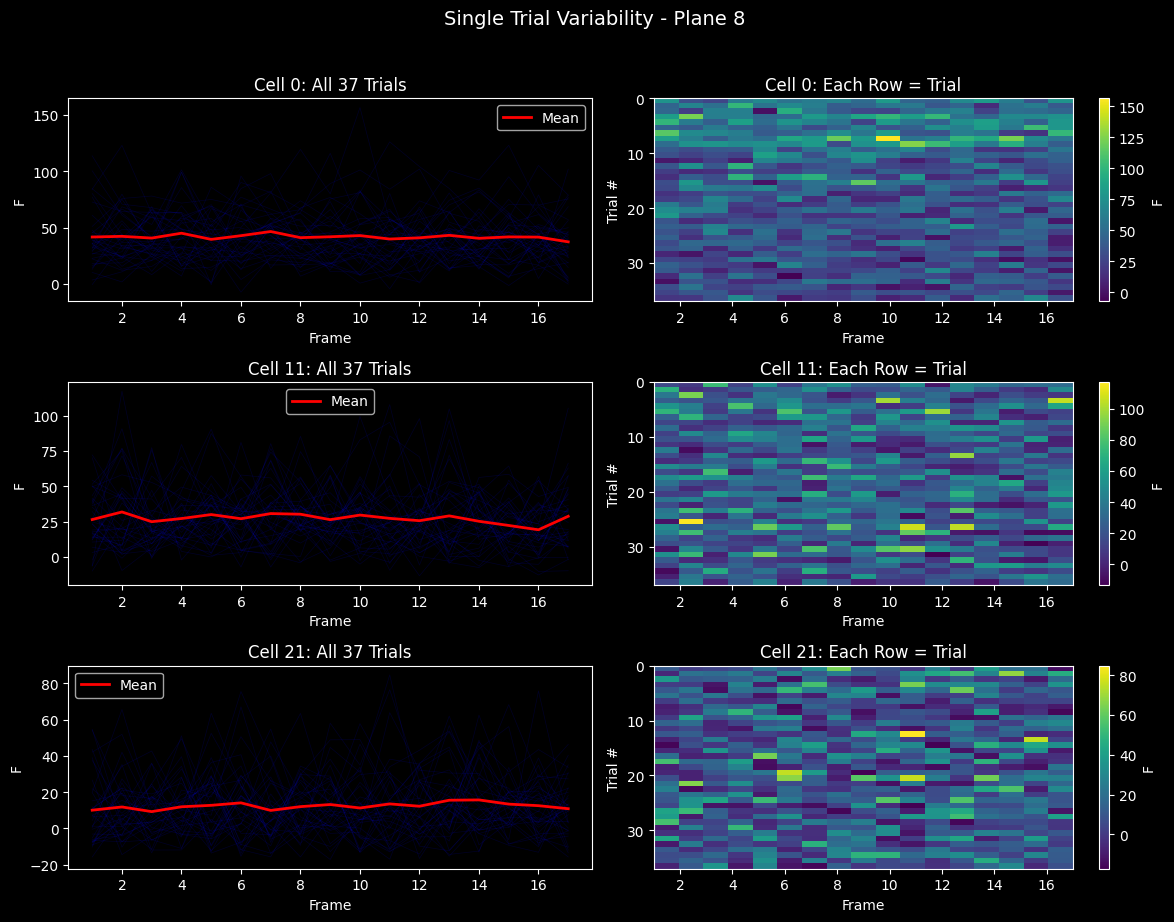

In [ ]:
# Single trial variability for example cells
example_plane = 8
F = traces_by_plane[example_plane]['F']
n_cells = F.shape[0]

# Get single trial traces
left_stim_trials = extract_trial_traces(F, frame_tables["left_stim"], n_frames=17, use_last_n=False)
print(f"Shape: {left_stim_trials.shape} (trials, cells, frames)")

# Show 3 example cells
example_cells = [0, n_cells//2, n_cells-1]
fig, axes = plt.subplots(len(example_cells), 2, figsize=(12, 3*len(example_cells)))
frames = np.arange(1, 18)

for row, cell_idx in enumerate(example_cells):
    cell_trials = left_stim_trials[:, cell_idx, :]

    # Overlaid traces
    ax = axes[row, 0]
    for trial in range(cell_trials.shape[0]):
        ax.plot(frames, cell_trials[trial], 'b-', alpha=0.15, linewidth=0.5)
    ax.plot(frames, cell_trials.mean(axis=0), 'r-', linewidth=2, label='Mean')
    ax.set_xlabel("Frame")
    ax.set_ylabel("F")
    ax.set_title(f"Cell {cell_idx}: All 37 Trials")
    ax.legend()

    # Heatmap
    ax = axes[row, 1]
    im = ax.imshow(cell_trials, aspect='auto', cmap='viridis',
                   extent=[1, 17, cell_trials.shape[0], 0])
    ax.set_xlabel("Frame")
    ax.set_ylabel("Trial #")
    ax.set_title(f"Cell {cell_idx}: Each Row = Trial")
    plt.colorbar(im, ax=ax, label='F')

plt.suptitle(f"Single Trial Variability - Plane {example_plane}", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Per-Plane Comparison

Does response differ by cortical depth? (Plane 1 = superficial, Plane 8 = deep)

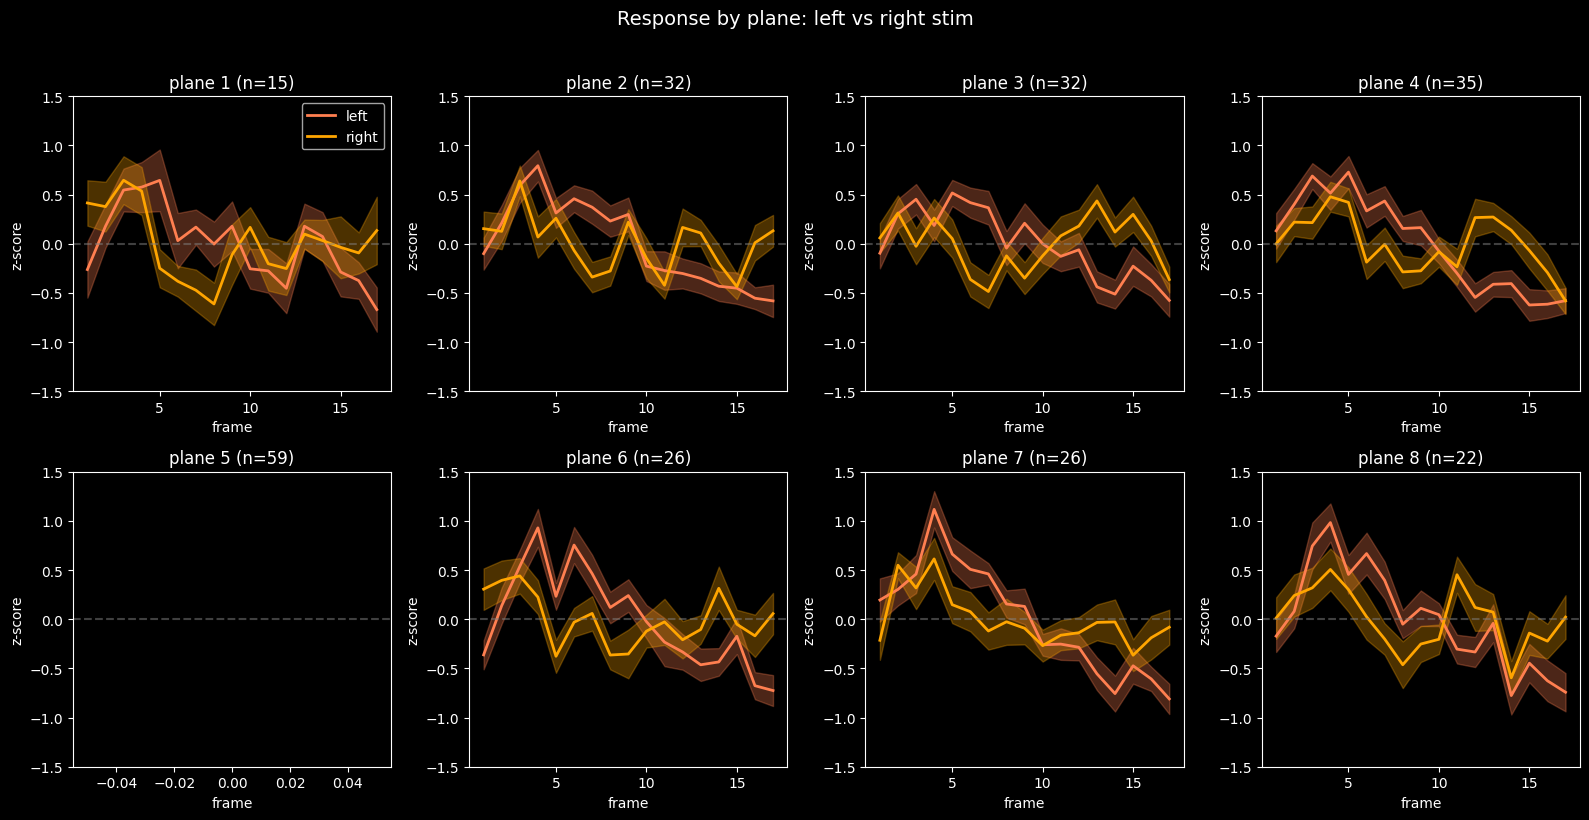

In [ ]:
# Per-plane population averages
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
frames = np.arange(1, 18)

for idx, plane_num in enumerate(planes_to_use):
    if plane_num not in traces_by_plane:
        continue

    F = traces_by_plane[plane_num]['F']
    n_cells = traces_by_plane[plane_num]['n_cells']

    # Skip if no cells
    if n_cells == 0:
        axes.flat[idx].set_visible(False)
        continue

    ax = axes.flat[idx]

    for cond, color, label in [('left_stim', 'coral', 'left'), ('right_stim', 'orange', 'right')]:
        traces = extract_trial_traces(F, frame_tables[cond], n_frames=17, use_last_n=False)
        trial_avg = traces.mean(axis=0)
        zdata = zscore_traces(trial_avg)

        mean = zdata.mean(axis=0)
        sem = zdata.std(axis=0) / np.sqrt(n_cells)
        ax.fill_between(frames, mean - sem, mean + sem, alpha=0.3, color=color)
        ax.plot(frames, mean, color=color, linewidth=2, label=label)

    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel("frame")
    ax.set_ylabel("z-score")
    ax.set_title(f"plane {plane_num} (n={n_cells})")
    ax.set_ylim(-1.5, 1.5)
    if idx == 0:
        ax.legend()

plt.suptitle("Response by plane: left vs right stim", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Summary

**Part 1**: Trial-averaged movies from raw pixels (data.bin)
- 17-frame movies for each condition
- 4D volumes for napari
- Difference movies (stim-before, left-right)

**Part 2**: Fluorescence traces from Suite2p ROIs
- Heatmaps: each row = cell, each column = frame 1-17
- Population averages: mean ± SEM across all cells
- Left/Right selectivity: which cells prefer which side?

**Part 3**: Clustering
- K-means groups cells by response similarity
- PCA shows cells in 2D space
- Single trial variability
- Per-plane breakdown

---

# Trace Validation


### Split-half reliability

Test if responses are consistent across trial halves using rastermap sorting.

In [ ]:
# split-half reliability using rastermap
F_all = np.vstack([traces_by_plane[p]['F'] for p in planes_to_use if p in traces_by_plane])
F_all_filtered = F_all[active_mask]
print(f"total cells: {F_all_filtered.shape[0]}")

left_stim_all_trials = extract_trial_traces(F_all_filtered, frame_tables["left_stim"], n_frames=17, use_last_n=False)
n_trials = left_stim_all_trials.shape[0]
print(f"trials shape: {left_stim_all_trials.shape} (trials, cells, frames)")

odd_trials = left_stim_all_trials[::2]
even_trials = left_stim_all_trials[1::2]
print(f"odd trials: {odd_trials.shape[0]}, even trials: {even_trials.shape[0]}")

odd_avg = odd_trials.mean(axis=0)
even_avg = even_trials.mean(axis=0)
odd_z = zscore_traces(odd_avg)
even_z = zscore_traces(even_avg)

# fit rastermap on odd trials
n_clust = min(50, odd_z.shape[0] // 4)
n_pcs = min(odd_z.shape[1], 17)
model_odd = Rastermap(n_clusters=n_clust, n_PCs=n_pcs, locality=0.0, verbose=False).fit(odd_z)
rastermap_order_odd = model_odd.isort

# fit rastermap on even trials
model_even = Rastermap(n_clusters=n_clust, n_PCs=n_pcs, locality=0.0, verbose=False).fit(even_z)
rastermap_order_even = model_even.isort

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("split-half reliability (rastermap)", fontsize=14)

# top row: rastermap sorted by odd, applied to both
ax = axes[0, 0]
im = ax.imshow(odd_z[rastermap_order_odd], aspect='auto', cmap='viridis',
               extent=[1, 17, len(rastermap_order_odd), 0], vmin=-2, vmax=2)
ax.set_xlabel("frame")
ax.set_ylabel("cells (rastermap on odd)")
ax.set_title(f"odd trials (n={odd_trials.shape[0]})")
plt.colorbar(im, ax=ax, label='z-score')

ax = axes[0, 1]
im = ax.imshow(even_z[rastermap_order_odd], aspect='auto', cmap='viridis',
               extent=[1, 17, len(rastermap_order_odd), 0], vmin=-2, vmax=2)
ax.set_xlabel("frame")
ax.set_ylabel("cells (same order)")
ax.set_title(f"even trials (n={even_trials.shape[0]})")
plt.colorbar(im, ax=ax, label='z-score')

# rastermap rank consistency
odd_ranks = np.argsort(rastermap_order_odd)
even_ranks = np.argsort(rastermap_order_even)
rank_corr = np.corrcoef(odd_ranks, even_ranks)[0, 1]

ax = axes[0, 2]
ax.scatter(odd_ranks, even_ranks, alpha=0.3, s=15)
ax.plot([0, len(odd_ranks)], [0, len(odd_ranks)], 'r--', linewidth=2)
ax.set_xlabel("rastermap rank (odd)")
ax.set_ylabel("rastermap rank (even)")
ax.set_title(f"rastermap rank consistency: r = {rank_corr:.2f}")

# bottom row: unsorted comparison and trace correlations
ax = axes[1, 0]
im = ax.imshow(odd_z, aspect='auto', cmap='viridis',
               extent=[1, 17, odd_z.shape[0], 0], vmin=-2, vmax=2)
ax.set_xlabel("frame")
ax.set_ylabel("cells (unsorted)")
ax.set_title("odd trials - unsorted")
plt.colorbar(im, ax=ax, label='z-score')

ax = axes[1, 1]
im = ax.imshow(even_z, aspect='auto', cmap='viridis',
               extent=[1, 17, even_z.shape[0], 0], vmin=-2, vmax=2)
ax.set_xlabel("frame")
ax.set_ylabel("cells (unsorted)")
ax.set_title("even trials - unsorted")
plt.colorbar(im, ax=ax, label='z-score')

# trace correlation histogram
cell_correlations = []
for i in range(odd_z.shape[0]):
    r = np.corrcoef(odd_z[i], even_z[i])[0, 1]
    if not np.isnan(r):
        cell_correlations.append(r)
cell_correlations = np.array(cell_correlations)

ax = axes[1, 2]
ax.hist(cell_correlations, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(cell_correlations), color='red', linestyle='--', linewidth=2,
           label=f'mean r = {np.mean(cell_correlations):.2f}')
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel("trace correlation (odd vs even)")
ax.set_ylabel("number of cells")
ax.set_title("split-half reliability per cell")
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nrastermap rank correlation: r = {rank_corr:.3f}")
print(f"trace correlation: mean r = {np.mean(cell_correlations):.3f}")
print(f"cells with r > 0.5: {(cell_correlations > 0.5).sum()} / {len(cell_correlations)}")
print(f"cells with r > 0.3: {(cell_correlations > 0.3).sum()} / {len(cell_correlations)}")

### Raw trace quality

Check if the raw fluorescence traces look like real calcium signals.

In [ ]:
# raw trace quality check
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle("raw trace quality check", fontsize=14)

# pick plane with most cells
plane_cell_counts = {p: traces_by_plane[p]['n_cells'] for p in planes_to_use if p in traces_by_plane}
example_plane = max(plane_cell_counts, key=plane_cell_counts.get)
F = traces_by_plane[example_plane]['F']
Fneu = traces_by_plane[example_plane]['Fneu']
n_cells_plane = F.shape[0]
n_total_frames = F.shape[1]

print(f"using plane {example_plane} with {n_cells_plane} cells")

# 1. distribution of mean F per cell
ax = axes[0, 0]
cell_means = F.mean(axis=1)
ax.hist(cell_means, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(cell_means.mean(), color='red', linestyle='--', label=f'mean={cell_means.mean():.0f}')
ax.set_xlabel('mean fluorescence (per cell)')
ax.set_ylabel('count')
ax.set_title(f'plane {example_plane}: distribution of cell brightness')
ax.legend()

# 2. distribution of std per cell
ax = axes[0, 1]
cell_stds = F.std(axis=1)
ax.hist(cell_stds, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(cell_stds.mean(), color='red', linestyle='--', label=f'mean={cell_stds.mean():.0f}')
ax.set_xlabel('std fluorescence (per cell)')
ax.set_ylabel('count')
ax.set_title('distribution of cell variability')
ax.legend()

# 3. example raw traces - pick cells with highest std (most active)
ax = axes[1, 0]
show_frames = min(3000, n_total_frames)
time = np.arange(show_frames) / 10.2

# select 5 most active cells
top_cells = np.argsort(cell_stds)[-5:][::-1]
trace_min = F[top_cells, :show_frames].min()
trace_max = F[top_cells, :show_frames].max()
offset = (trace_max - trace_min) * 0.25

for i, cell_idx in enumerate(top_cells):
    trace = F[cell_idx, :show_frames]
    ax.plot(time, trace + i * offset, alpha=0.8, linewidth=0.5, label=f'cell {cell_idx}')

ax.set_xlabel('time (s)')
ax.set_ylabel('F (offset for visibility)')
ax.set_title(f'top 5 most active cells (first {show_frames} frames)')
ax.legend(loc='upper right', fontsize=8)

# 4. F vs Fneu scatter
ax = axes[1, 1]
ax.scatter(F.mean(axis=1), Fneu.mean(axis=1), alpha=0.5, s=20)
corr = np.corrcoef(F.mean(axis=1), Fneu.mean(axis=1))[0, 1]
ax.set_xlabel('mean F (cell body)')
ax.set_ylabel('mean Fneu (neuropil)')
ax.set_title(f'cell vs neuropil (r={corr:.2f})')
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'r--', alpha=0.5, label='1:1 line')
ax.legend()

# 5. trial-aligned traces for most active cell
ax = axes[2, 0]
cell_idx = top_cells[0]
trials = extract_trial_traces(F, frame_tables["left_stim"], n_frames=17, use_last_n=False)
cell_trials = trials[:, cell_idx, :]

for trial in range(cell_trials.shape[0]):
    ax.plot(range(1, 18), cell_trials[trial], 'b-', alpha=0.15, linewidth=0.5)
ax.plot(range(1, 18), cell_trials.mean(axis=0), 'r-', linewidth=2, label='mean')
ax.set_xlabel('frame')
ax.set_ylabel('F')
ax.set_title(f'cell {cell_idx}: all 37 left stim trials')
ax.legend()

# 6. coefficient of variation per cell
ax = axes[2, 1]
cv = cell_stds / (cell_means + 1e-6)
ax.hist(cv, bins=30, color='green', edgecolor='black', alpha=0.7)
ax.axvline(cv.mean(), color='red', linestyle='--', label=f'mean CV={cv.mean():.3f}')
ax.set_xlabel('CV (std/mean)')
ax.set_ylabel('count')
ax.set_title('coefficient of variation')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nplane {example_plane} statistics:")
print(f"  cells: {n_cells_plane}")
print(f"  frames: {n_total_frames}")
print(f"  mean F: {F.mean():.1f}")
print(f"  mean cell std: {cell_stds.mean():.1f}")
print(f"  mean CV: {cv.mean():.4f}")

### Single-trial heatmaps

Show individual trials (not averaged) to see trial-by-trial variability.

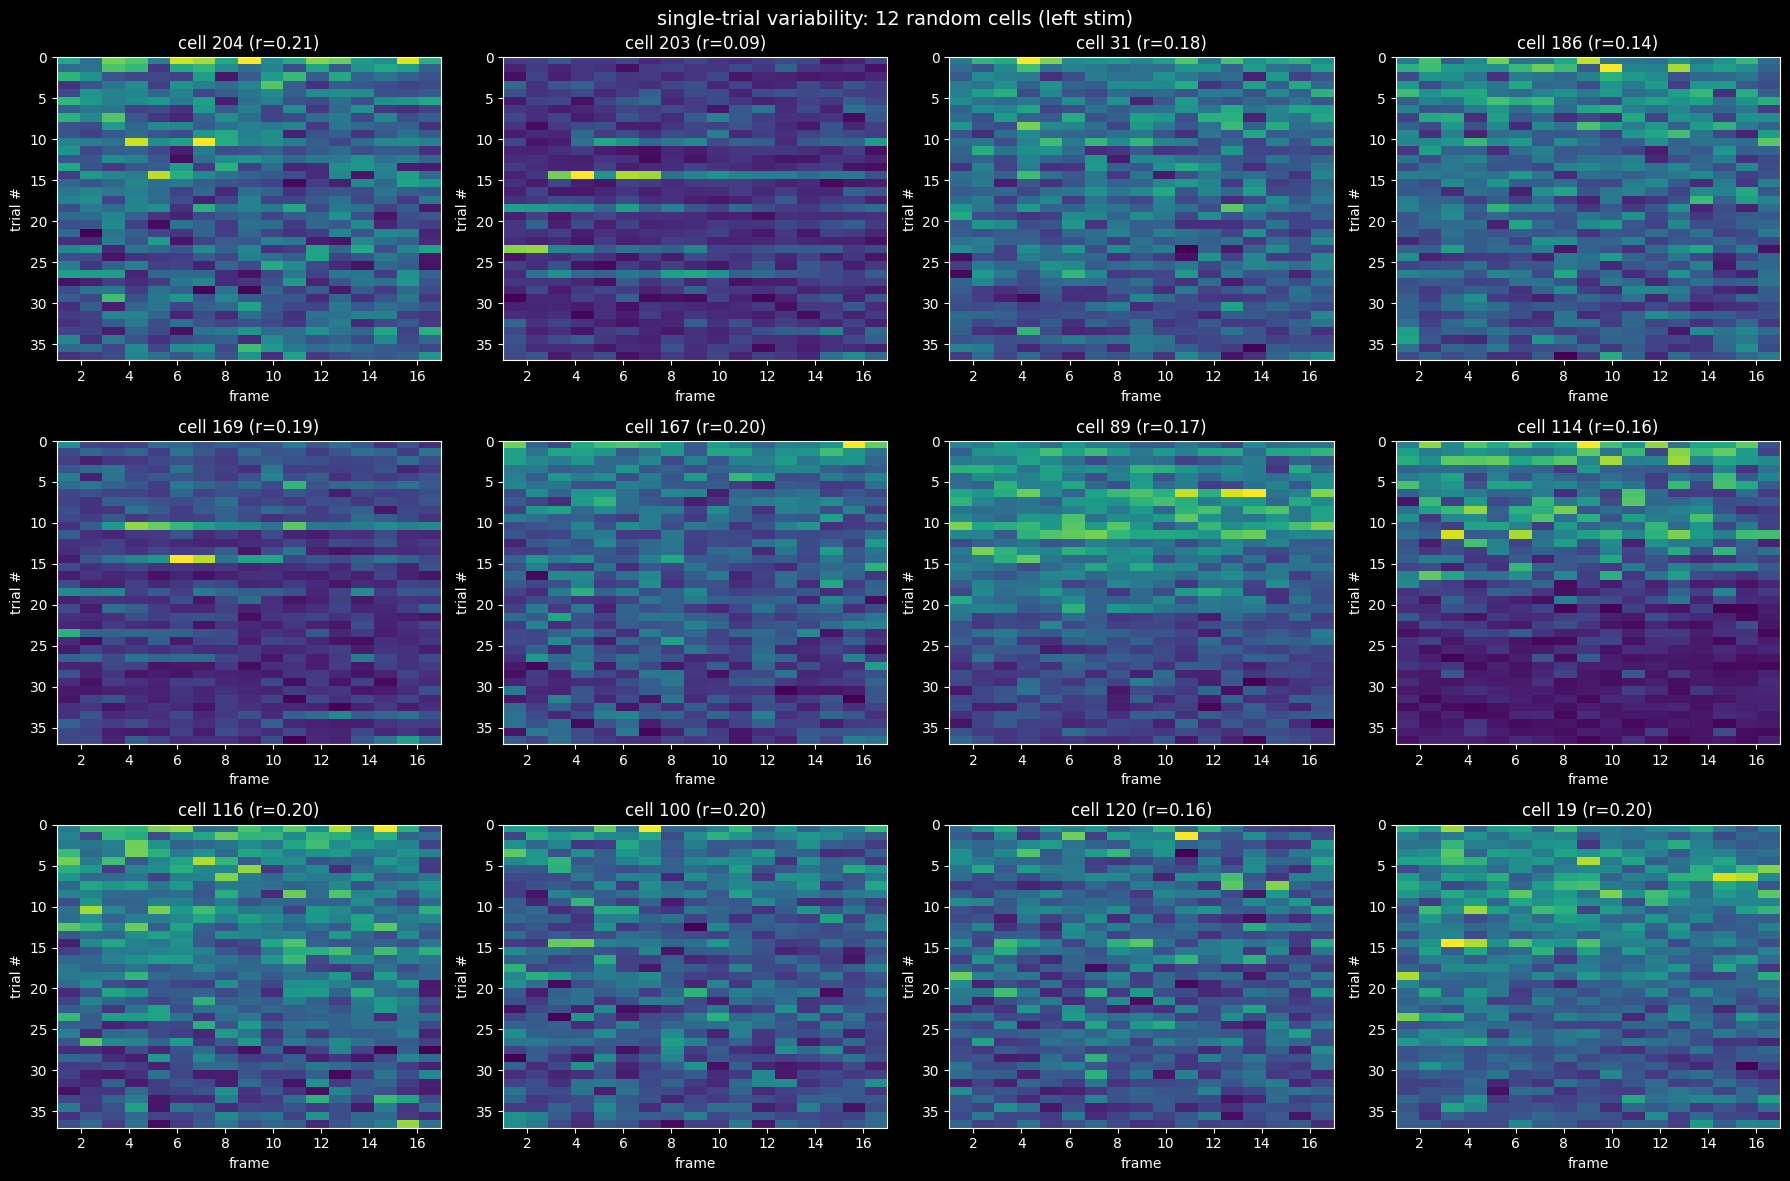

In [ ]:
# single-trial heatmaps for multiple cells using filtered data
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle("single-trial variability: 12 random cells (left stim)", fontsize=14)

np.random.seed(123)
n_filtered = F_all_filtered.shape[0]
example_cells = np.random.choice(n_filtered, min(12, n_filtered), replace=False)

for idx, cell_idx in enumerate(example_cells):
    ax = axes.flat[idx]
    cell_trials = left_stim_all_trials[:, cell_idx, :]

    im = ax.imshow(cell_trials, aspect='auto', cmap='viridis',
                   extent=[1, 17, cell_trials.shape[0], 0])
    ax.set_xlabel("frame")
    ax.set_ylabel("trial #")

    mean_trace = cell_trials.mean(axis=0)
    trial_corrs = [np.corrcoef(cell_trials[t], mean_trace)[0,1]
                   for t in range(cell_trials.shape[0])]
    mean_r = np.nanmean(trial_corrs)

    ax.set_title(f"cell {cell_idx} (r={mean_r:.2f})")

plt.tight_layout()
plt.show()

### Global artifact check

Check for global signals affecting all cells (motion artifact, photobleaching).

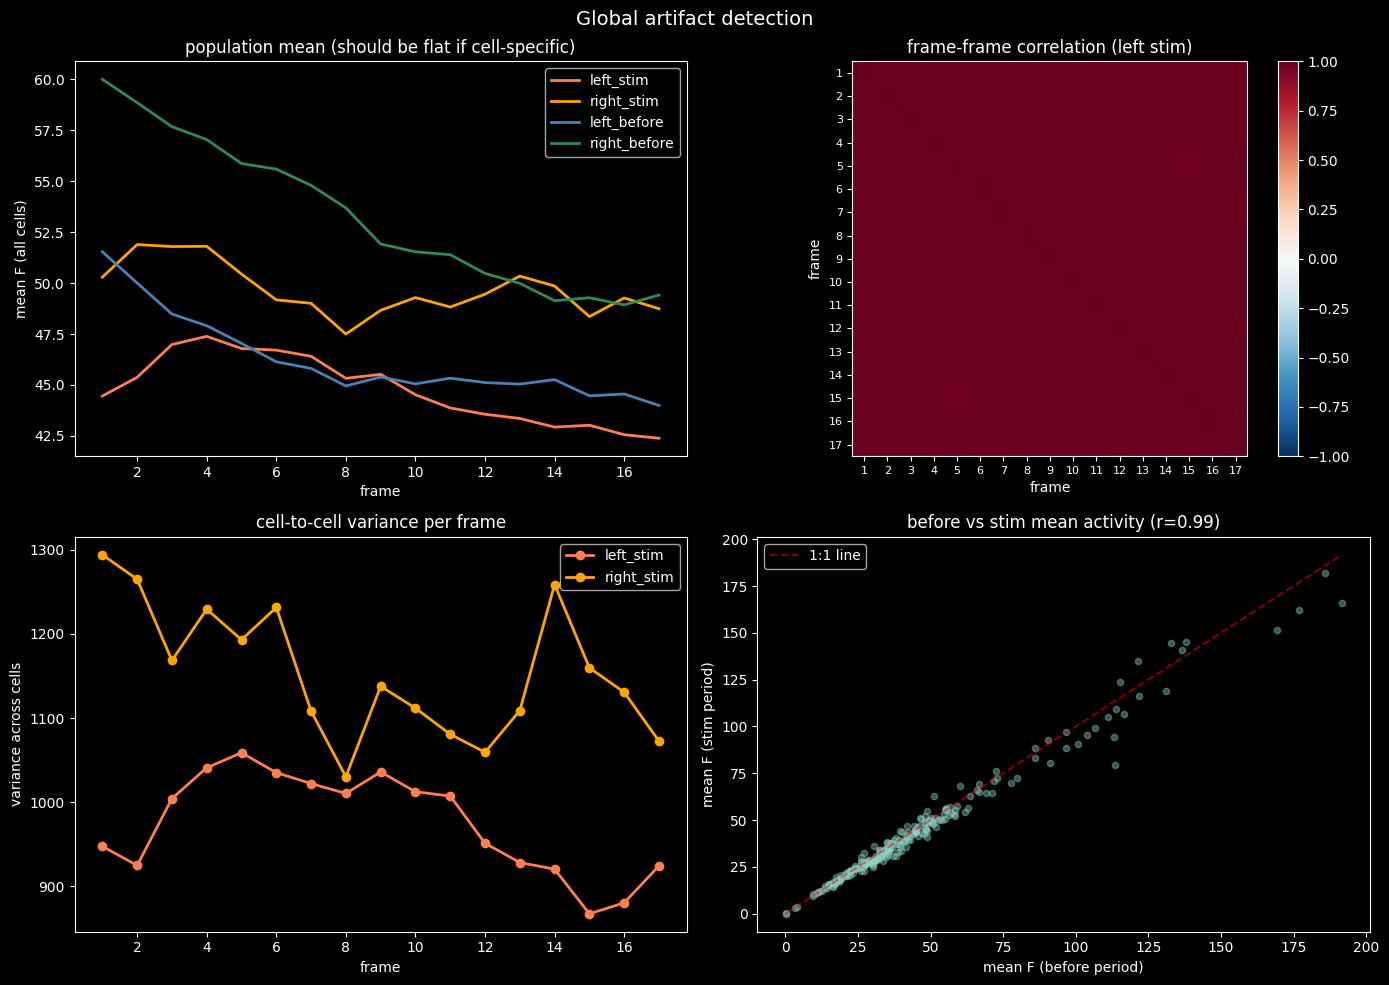


Frame-frame correlation stats:
  Mean off-diagonal: 0.984
  Max off-diagonal: 0.989
  If mean > 0.5, may indicate global artifact


In [ ]:
# Global artifact check
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Global artifact detection", fontsize=14)

# 1. Population mean trace (raw F, not z-scored)
ax = axes[0, 0]
for cond, color in [('left_stim', 'coral'), ('right_stim', 'orange'),
                     ('left_before', 'steelblue'), ('right_before', 'seagreen')]:
    mean_trace = all_traces_filtered[cond].mean(axis=0)  # Mean across all cells
    ax.plot(range(1, 18), mean_trace, color=color, linewidth=2, label=cond)
ax.set_xlabel('frame')
ax.set_ylabel('mean F (all cells)')
ax.set_title('population mean (should be flat if cell-specific)')
ax.legend()

# 2. Frame-to-frame correlation matrix
ax = axes[0, 1]
data = all_traces_filtered['left_stim']
corr_matrix = np.corrcoef(data.T)  # 17x17 correlation between frames
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('frame')
ax.set_ylabel('frame')
ax.set_title('frame-frame correlation (left stim)')
ax.set_xticks(range(17))
ax.set_xticklabels(range(1, 18), fontsize=8)
ax.set_yticks(range(17))
ax.set_yticklabels(range(1, 18), fontsize=8)
plt.colorbar(im, ax=ax)

# 3. Variance per frame (should be similar across frames)
ax = axes[1, 0]
for cond, color in [('left_stim', 'coral'), ('right_stim', 'orange')]:
    var_trace = all_traces_filtered[cond].var(axis=0)
    ax.plot(range(1, 18), var_trace, color=color, linewidth=2, marker='o', label=cond)
ax.set_xlabel('frame')
ax.set_ylabel('variance across cells')
ax.set_title('cell-to-cell variance per frame')
ax.legend()

# 4. Before vs Stim mean comparison
ax = axes[1, 1]
before_mean = all_traces_filtered['left_before'].mean(axis=1)
stim_mean = all_traces_filtered['left_stim'].mean(axis=1)
ax.scatter(before_mean, stim_mean, alpha=0.4, s=20)
corr = np.corrcoef(before_mean, stim_mean)[0, 1]
ax.set_xlabel('mean F (before period)')
ax.set_ylabel('mean F (stim period)')
ax.set_title(f'before vs stim mean activity (r={corr:.2f})')
# Add 1:1 line
lims = [min(before_mean.min(), stim_mean.min()), max(before_mean.max(), stim_mean.max())]
ax.plot(lims, lims, 'r--', alpha=0.5, label='1:1 line')
ax.legend()

plt.tight_layout()
plt.show()

# Check for high global correlation (artifact indicator)
off_diag = corr_matrix[np.triu_indices(17, k=1)]
print(f"\nFrame-frame correlation stats:")
print(f"  Mean off-diagonal: {off_diag.mean():.3f}")
print(f"  Max off-diagonal: {off_diag.max():.3f}")
print(f"  If mean > 0.5, may indicate global artifact")

### Cross-condition consistency

Check if cells maintain their identity across conditions.